# Segmentation d'objet 3D (xyz) 

In [40]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2

from mpl_toolkits.mplot3d import Axes3D # module 3D de Matplotlib

## Lecture et Visualisation d'une scène 3D 

Ici on considère un fichier de coordonnées xyz (3 colonnes séparées par des espace)

In [41]:
df=pd.read_table("D:/1Enseignement/PythonSIG/segCloud/plante.xyz",sep=" ")
df.shape
# nommage des colonnes
df.columns=['x','y','z']

Visualisation 3D

Text(0.5, 0, 'z')

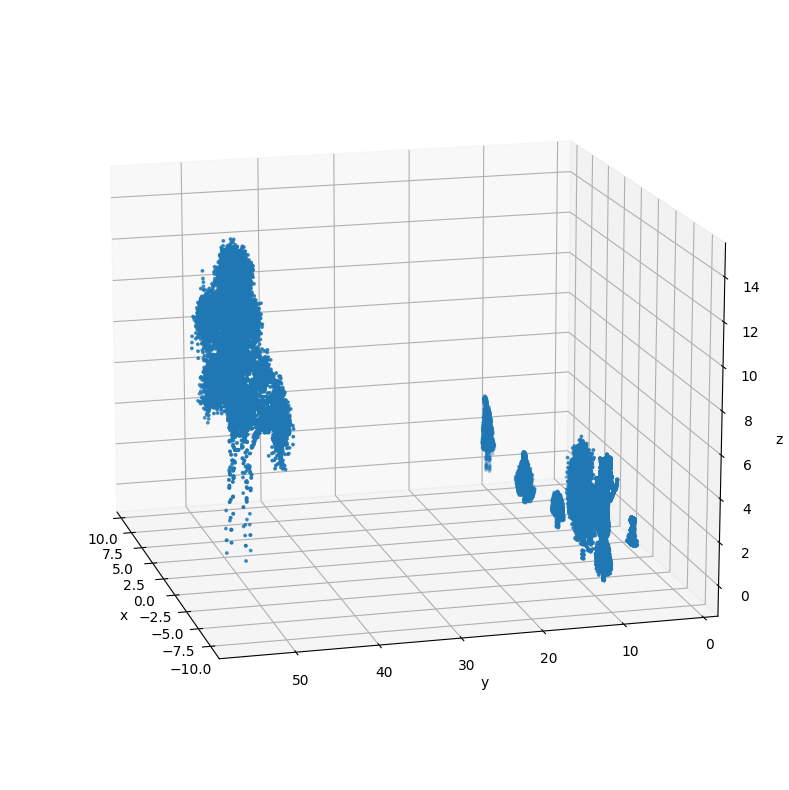

In [42]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.scatter(df['x'], df['y'], df['z'],s=3)  
ax.view_init(15, 165)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

## Segmentation par Algorithme des kmeans (nuées dynamiques)

Un objet a des pixels voisins (et couleurs ou textures proches, informations non fournies dans le fichier). 

L'algorithme des Kmeans est une technique de segmentation visant à partitionner des données en K classes selon leur proximité à leur centre. Les centres sont initiés aléatoirement puis recalculés afin d'obtenir une convergence (pas de nouvelles affectations d'un pixel à un centre). A chaque iteration, un pixel est assigné au centre le plus proche et le centre est ainsi recalculé.

Sans connaissance a priori sur le nombre d'objets K de la scène, on évalue le nombre d'objets (dits classes) en calculant l'inertie intra-classe (distance entre les coordonnées d'un objet et son centre - SSE). 

Il a pour inconvenient de ne considérer que des formes convexes et linairement séparables.
Mais par sa rapidité de calcul et l'absence de paramétrage associé (hormis K), il reste parmi ceux les plus utilisés.



In [51]:
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# normalisation des données (si besoin / selon application)
#scaler = StandardScaler()
#X = scaler.fit_transform(df)
X=df

# Estimation de K  
# calcul de l'inertie SSE pour chaque K 
sse = []
Kmax=20 # on suppose ici que nous avons moins de 20 objets
for k in range(2, Kmax):
    kmeans = KMeans(init="random",n_clusters=k,n_init=10,max_iter=300,random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

kl = KneeLocator(range(2, Kmax), sse, curve="convex", direction="decreasing")
K=kl.elbow
print("Estimated K by Elbow method on SSE=", K)


Estimated K by Elbow method on SSE= 6


Application sur le nombre K estimé.

In [52]:
km = KMeans(init="random",n_clusters=K,n_init=10,max_iter=300,random_state=0)
km.fit(X)
print(f"SSE inertia : {km.inertia_}")
print(f"Centroid coordinates: \n{km.cluster_centers_}")
print(f"Iteration number to converge: {km.n_iter_}")
labels=km.labels_

SSE inertia : 808316.4180413291
Centroid coordinates: 
[[-1.34586567 50.43639844  9.9241109 ]
 [-3.94025851  3.64582431  1.31150695]
 [ 8.82141597 11.00149216  1.9902376 ]
 [ 0.83878623 10.11510723  1.10343699]
 [-7.89014201 10.71925744  1.90838932]
 [ 1.55401457  4.11169939  0.35608713]]
Iteration number to converge: 6


Visualisation 3D de la segmentation

Text(0.5, 0, 'z')

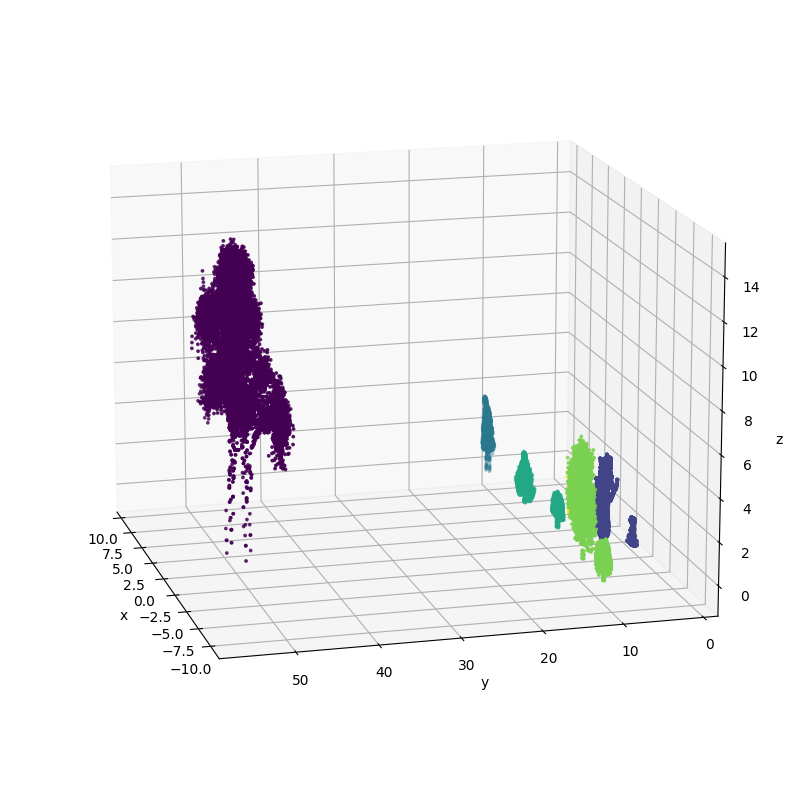

In [53]:
fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.scatter(df['x'], df['y'], df['z'],c=labels,s=3)  
ax.view_init(15, 165)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


Rendu 2D selon chaque plan

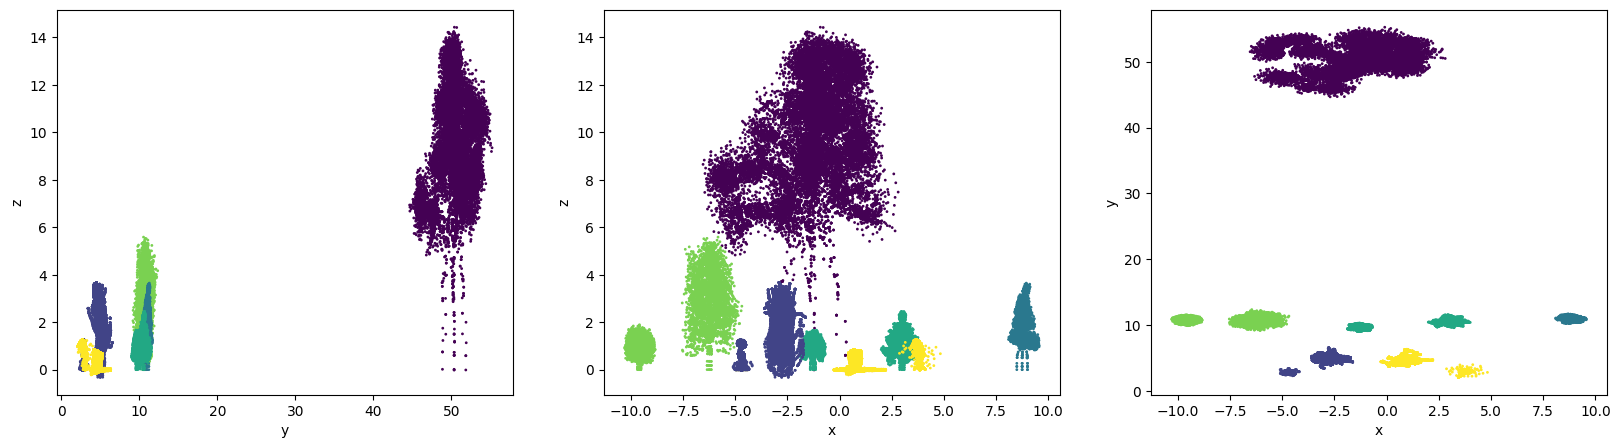

In [54]:
fig, m_axs = plt.subplots(1, 3, figsize = (20, 5))
ax_names = 'xyz'
for i, c_ax in enumerate(m_axs.flatten()):
    plot_axes = [x for j, x in enumerate(ax_names) if j!=i]
    c_ax.scatter(df[plot_axes[0]],
                df[plot_axes[1]],
                c=labels, 
                s=1
                )
    c_ax.set_xlabel(plot_axes[0])
    c_ax.set_ylabel(plot_axes[1])

Calcul du nombre de Pixels associés à chaque objet détecté.

In [32]:
NPixelClasse = pd.Series(labels).value_counts()
print(NPixelClasse)

2    59561
0    48699
1    33015
3    28862
4    21456
dtype: int64


## Visualisation d'un maillage.

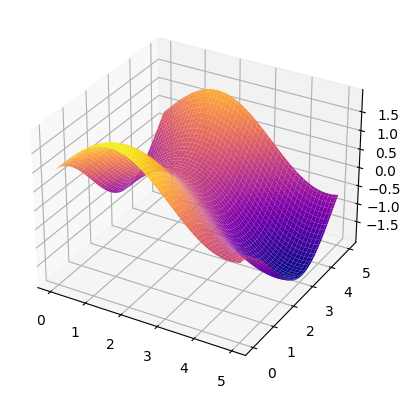

In [55]:
# Création d'une fonction
f = lambda x, y: np.sin(x) + np.cos(y)
# Création d'un domaine d'étude X, Y
x = np.linspace(0, 5, 100)
y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)
# Résultat : tableau numpy 2D
Z = f(X, Y)
# Affichage de la surface
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')

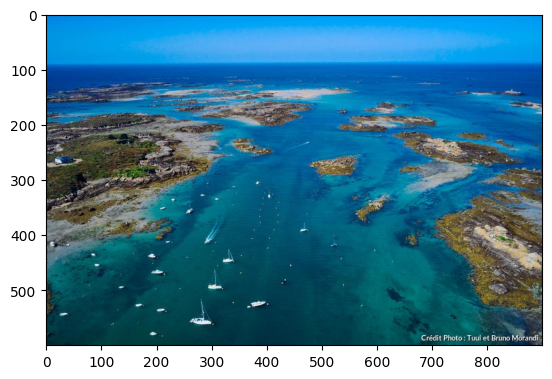

In [72]:
## Application sur image 2D

img=cv2.imread("D:/1Enseignement/PythonSIG/image/chausey.jpg")
#img=cv2.imread("D:/1Enseignement/PythonSIG/image/maison.jpeg")
imgRGB=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(imgRGB)


Passage d'une matrice d'image à un dataframe (y,x,r,g,b)

In [78]:
A=imgRGB

# Create the multiindex we'll need for the series
index = pd.MultiIndex.from_product(
    (*map(range, A.shape[:2]), ('r', 'g', 'b')),
    names=('row', 'col', None)
)

# Can be chained but separated for use in explanation
df2 = pd.Series(A.flatten(), index=index)
df2 = df2.unstack()
df2 = df2.reset_index().reindex(columns=['col', 'row', 'r', 'g', 'b'])

Segmentation Kmeans

Estimated K by Elbow method on SSE= 5


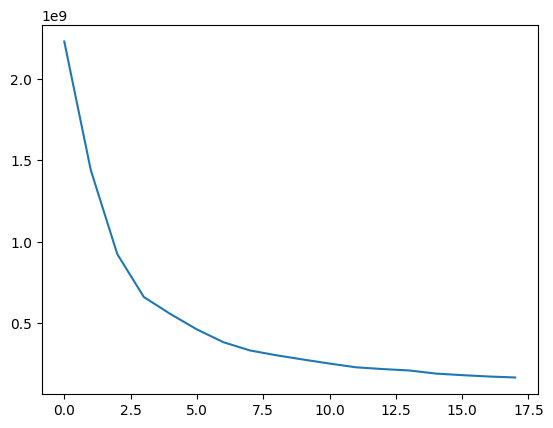

In [82]:
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X=df2
X=df2[['r', 'g', 'b']]

# Estimation de K  
# calcul de l'inertie SSE pour chaque K 
sse = []
Kmax=20 # on suppose ici que nous avons moins de 20 objets
for k in range(2, Kmax):
    kmeans = KMeans(init="random",n_clusters=k,n_init=10,max_iter=300,random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

kl = KneeLocator(range(2, Kmax), sse, curve="convex", direction="decreasing")
K=kl.elbow
print("Estimated K by Elbow method on SSE=", K)

plt.plot(sse)


In [83]:
km = KMeans(init="random",n_clusters=K,n_init=10,max_iter=300,random_state=0)
km.fit(X)
print(f"SSE inertia : {km.inertia_}")
print(f"Centroid coordinates: \n{km.cluster_centers_}")
print(f"Iteration number to converge: {km.n_iter_}")
labels2=km.labels_


SSE inertia : 660197223.5795124
Centroid coordinates: 
[[ 82.42832124  79.82289747  66.23943018]
 [  4.31494005  70.1454958   85.02483845]
 [ 28.69771959 162.34047391 238.45989855]
 [139.44211122 148.31319217 148.92739042]
 [  5.79970688 103.27526981 155.8230417 ]]
Iteration number to converge: 21


Visualisation des objets détectés

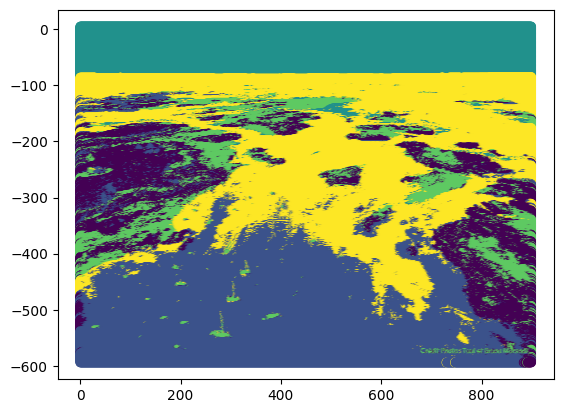

In [84]:
plt.scatter(df2['col'],df2.shape[1]-df2['row'],c=labels2)